# Uncertainty Analysis


## This code is for calculating & graphing the uncertainty of the OPGEE model. 


Currently looks at ten real fields and the sensitivity baseline from OPGEEv3

Further work is needed to analyze the uncertainty of OPGEEv4

In [2]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

### Loading data and adding simple stats

In [3]:
statistics = pd.read_csv('./data/uncertainty1_outputs.csv') # load in data of one hundred runs for ten fields plus baseline

In [4]:
diff = statistics.apply(lambda x: x - x.mean())             # finding the difference from the mean
median_diff = statistics.apply(lambda x: x - x.median())    # finding the difference from the median

### Stacked Bar Plots

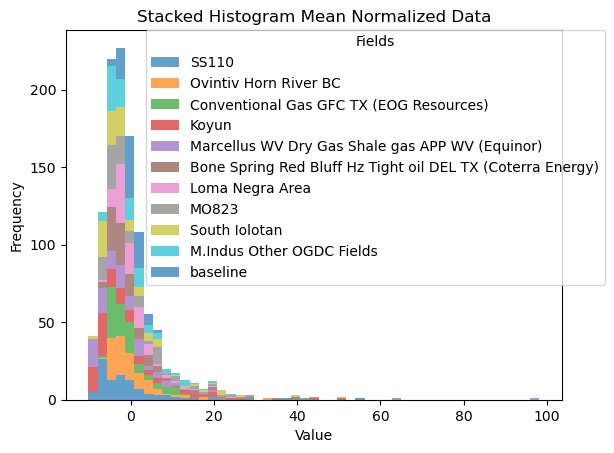

In [5]:
# Plotting the stacked histogram
diff.plot(kind='hist', stacked=True, bins=49, alpha=0.7)

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Stacked Histogram Mean Normalized Data')
plt.legend(title='Fields',loc='upper right',bbox_to_anchor=[1.1, 1.02])
plt.show()


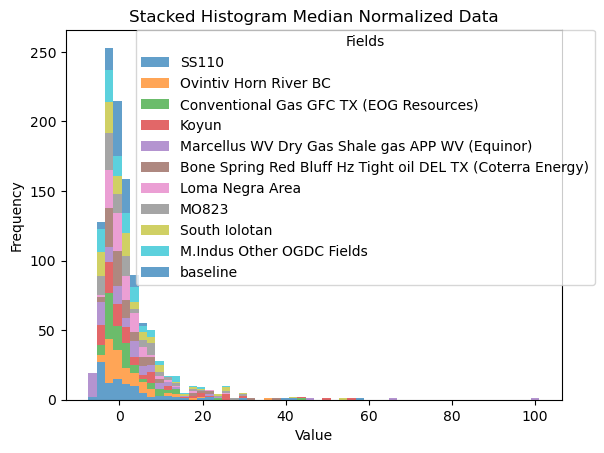

In [6]:
# Plotting the stacked histogram
median_diff.plot(kind='hist', stacked=True, bins=54, alpha=0.7)

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Stacked Histogram Median Normalized Data')
plt.legend(title='Fields',loc='upper right',bbox_to_anchor=[1.08, 1.02])
plt.show()


### Adding more statistics

In [7]:
# adding new rows for each statistic per field

statistics.loc['mean'] = statistics.mean()
statistics.loc['median'] = statistics.median()
statistics.loc['st_dev'] = statistics.std()
statistics.loc['min'] = statistics.min()
statistics.loc['max'] = statistics.max()

In [8]:
# Calculate ninety percent confidence interval for each column

confidence_intervals = statistics.apply(lambda x: stats.t.interval(
    0.9, len(x.dropna())-1, loc=x.dropna().mean(), scale=stats.sem(x.dropna())))

In [9]:
statistics.loc['ci_lower'] = confidence_intervals.loc[0]                                                                # adding row for confidence interval
statistics.loc['ci_upper'] = confidence_intervals.loc[1]                                                                

statistics.loc['ci_pct_under'] = (statistics.loc['ci_lower'] - statistics.loc['mean'])/statistics.loc['mean'] * 100     # finding percent change of confidence
statistics.loc['ci_pct_over'] = (statistics.loc['ci_upper'] - statistics.loc['mean'])/statistics.loc['mean'] * 100

# make a new column that has the greater of the two confidence interval percents in order to capture the worst case scenario uncertainty 

statistics.loc['plusminus'] = statistics.apply(
    lambda x: x.loc['ci_pct_under'] if abs(
        x.loc['ci_pct_under']) > abs(
            x.loc['ci_pct_over']) else x.loc['ci_pct_over']
)

In [10]:
# statistics on the statistics

print(f'Average Standard Deviation is {np.mean(statistics.loc['st_dev'])}')
print(f'Standard Devation of the Standard Deviations is {np.std(statistics.loc['st_dev'])}')

Average Standard Deviation is 7.758445418267858
Standard Devation of the Standard Deviations is 3.2407222223842993


In [11]:
# turning the index back into field names, and shortening names so they fit on the graph

df = statistics.T
df['name'] = df.index
df['short_name'] = df['name'].apply(
    lambda x: (x[:10] + '...') if len(x) > 10 else x)

### Plotting graph with y error bars

In [12]:
# for coloring the bars

norm = Normalize(vmin=(df['mean']-df['median']).min(), vmax=(df['mean']-df['median']).max())    # create a normalized range of values
cmap = cm.Wistia                                                                                # setting colormap
colors = cmap(norm((df['mean']-df['median'])))                                                  # applying the colors based upon values

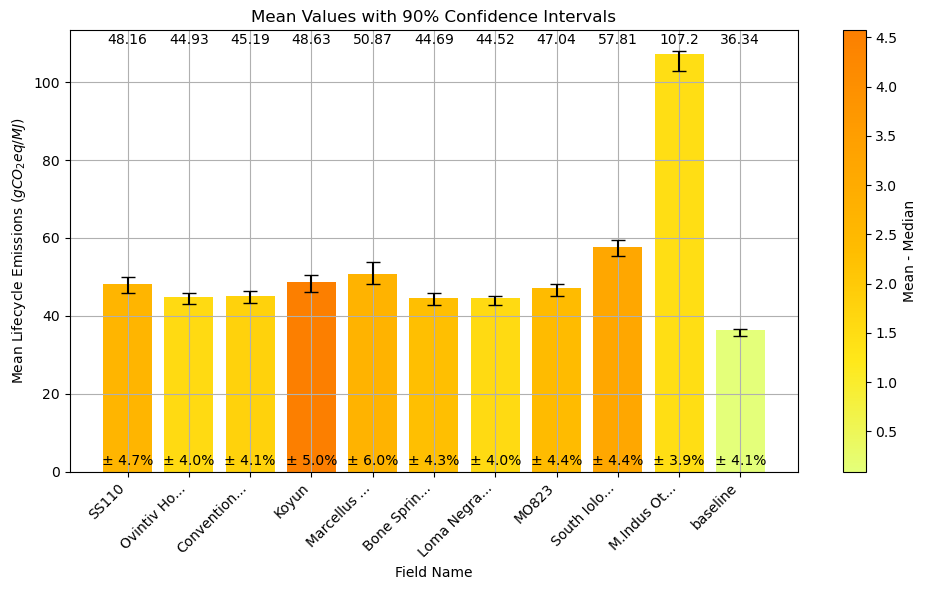

In [13]:
# making the plot

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(df['short_name'], df['mean'],                                     # creating the bars
              yerr=[df['mean'] - df['ci_lower'], df['ci_upper'] - df['mean']],  # adding y errors calculated earlier
              capsize=5, color=colors)                                          # adding the colors

ax.set_xlabel('Field Name')
ax.set_ylabel(r'Mean Lifecycle Emissions $(gCO_{2}eq/MJ)$')
ax.set_title('Mean Values with 90% Confidence Intervals')

# for adding the plus minus label at the bottom of the bars and the height at the top of the graph
for bar, label in zip(bars, df['plusminus']):                                   # zip the bars variable to the plusminus column
    height = bar.get_height()                                                   # find the value of the bar
    label = abs(label)                                                          # label is the value in the plusminus column
    ax.text(bar.get_x() + bar.get_width() / 2, 1,                               # locates where plusminus label will go
            f'{'\u00B1'} {label:.2}%', ha='center', va='bottom')                # writes the plusminus label with the symbol
    ax.text(bar.get_x() + bar.get_width() / 2, 109,                             # locates where bar height label will go
            f'{height:.4}', ha='center', va='bottom')                           # writes the bar value label

# Add colorbar with axis label
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Mean - Median')

ax.set_xticks(range(len(df['short_name'])))
ax.set_xticklabels(df['short_name'], rotation=45, ha='right')                   # rotate labels so they fit better
ax.grid(True)
plt.tight_layout()
plt.show()